In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
sns.set()
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)


In [4]:
# https://github.com/statsmodels/statsmodels/issues/2788
def make_predictions_sarimax(trn_series, tst_series, order=(2, 0, 0)):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        
    return predictions
    

We choose training set 1 to fit our ARMA. This is because there are no attacks in this training set --> we can learn the normal behaviour

2014-01-06 00:00:00    0.509730
2014-01-06 01:00:00    0.412580
2014-01-06 02:00:00    0.320112
2014-01-06 03:00:00    0.332879
2014-01-06 04:00:00    0.483496
Freq: H, Name: L_T1, dtype: float64


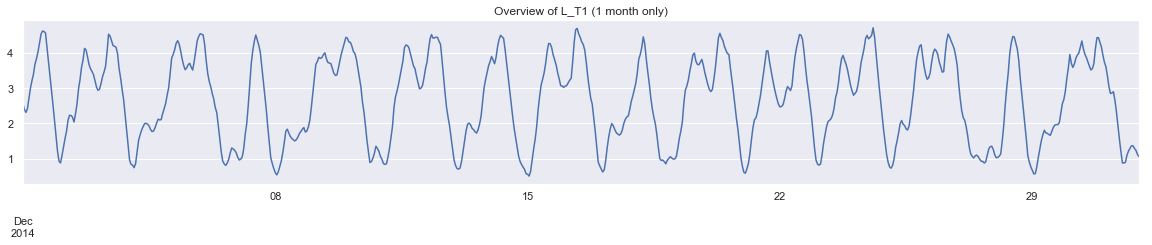

8641 hours used for training, 120 for testing.


C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


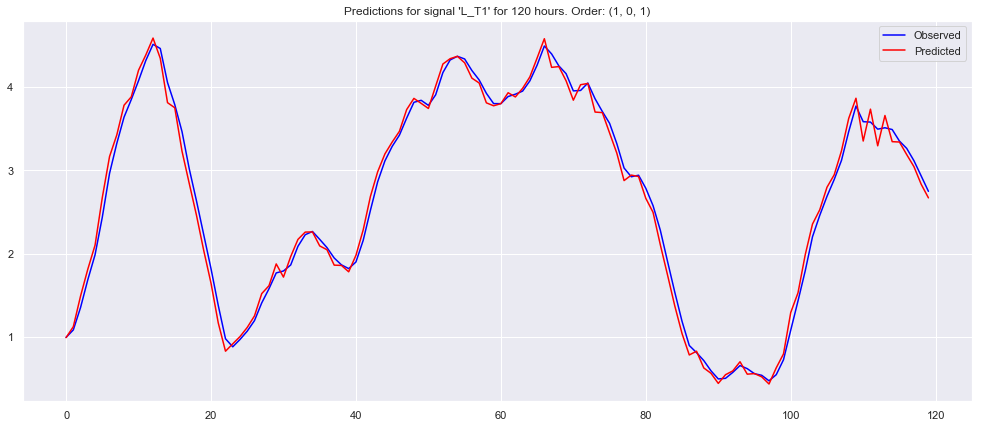

MSE: 0.011882579983425201
2014-01-06 00:00:00    98.998444
2014-01-06 01:00:00    99.095901
2014-01-06 02:00:00    98.420959
2014-01-06 03:00:00    97.575172
2014-01-06 04:00:00    97.351059
Freq: H, Name: F_PU1, dtype: float64


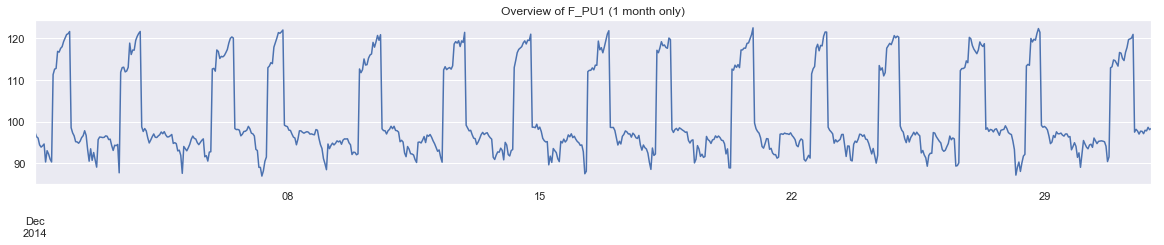

8641 hours used for training, 120 for testing.


C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


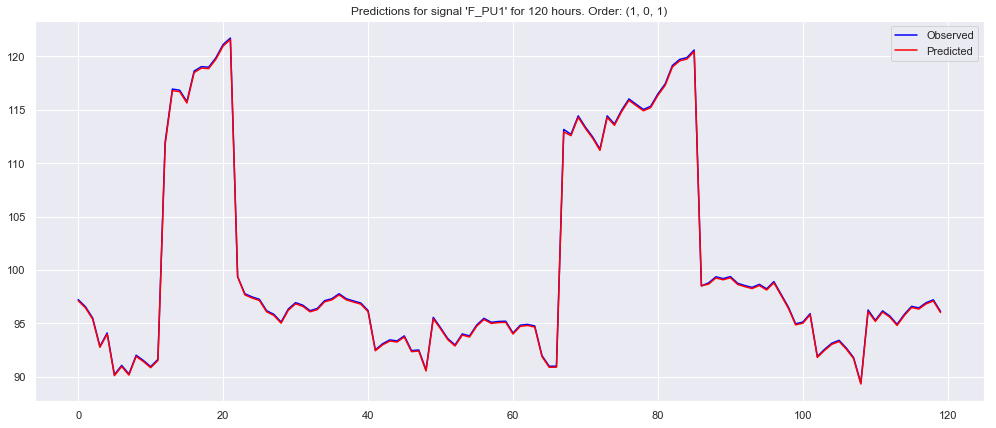

MSE: 0.012683485117106506
2014-01-06 00:00:00    99.018150
2014-01-06 01:00:00    99.115639
2014-01-06 02:00:00    98.440498
2014-01-06 03:00:00    97.594460
2014-01-06 04:00:00    97.370277
Freq: H, Name: F_PU2, dtype: float64


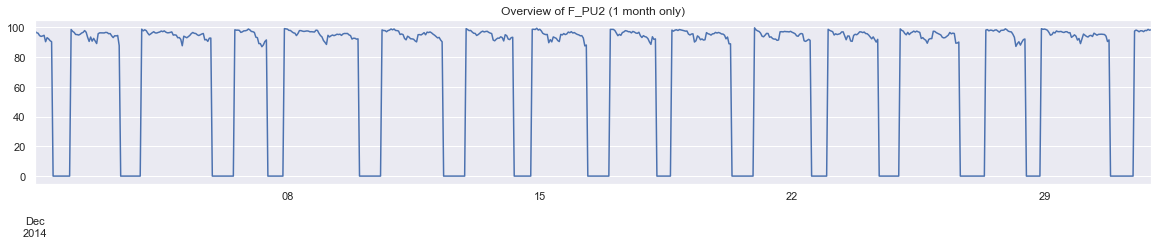

8641 hours used for training, 120 for testing.


C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


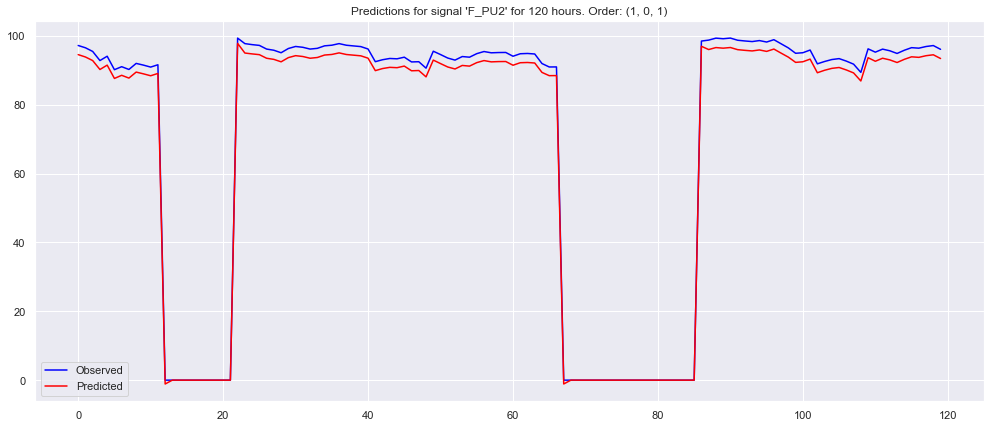

MSE: 5.189522274814484
2014-01-06 00:00:00    2.974053
2014-01-06 01:00:00    2.974005
2014-01-06 02:00:00    2.974333
2014-01-06 03:00:00    2.974740
2014-01-06 04:00:00    2.974847
Freq: H, Name: P_J280, dtype: float64


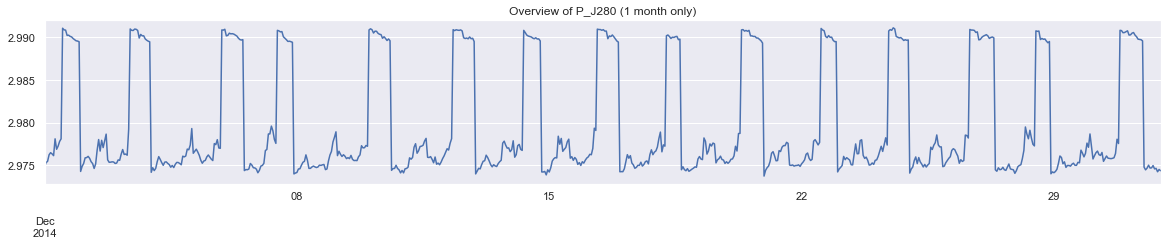

8641 hours used for training, 120 for testing.


C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


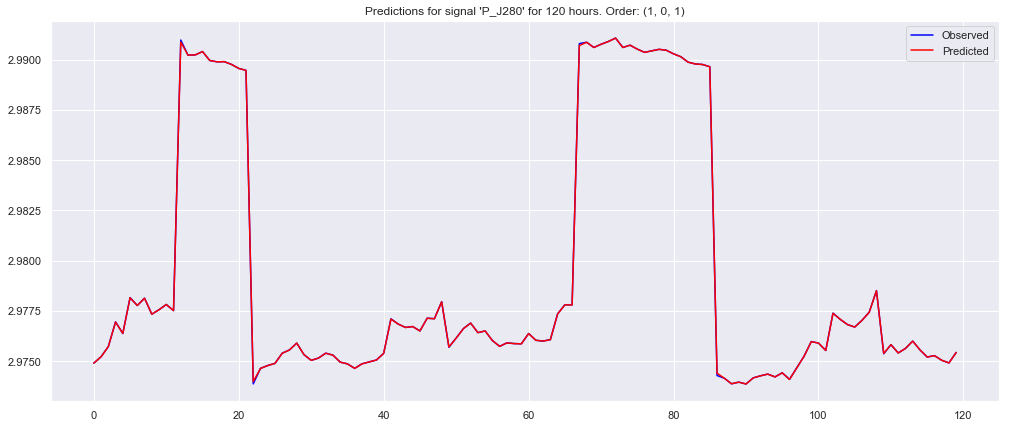

MSE: 4.0957441556875655e-10


In [5]:
for signal in ['L_T1', 'F_PU1', 'F_PU2', 'P_J280']:
    signal_data = data[signal]
    #print("{} data points for signal '{}'".format(signal_data.shape[0], signal))
    print(signal_data.head(5))
    
    signal_data.loc['2014-12'].plot(figsize=(20, 3), title=f"Overview of {signal} (1 month only)")
    plt.show()
    
    hours_to_predict = 24 * 5
    split_point = len(signal_data) - hours_to_predict 

    train = signal_data.iloc[0:split_point]
    test = signal_data.iloc[split_point:]
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    order = (1, 0, 1)
    predictions = make_predictions_sarimax(train, test, order)

    plt.figure(figsize=(17,7))
    plt.plot(test.values, color='blue', label='Observed')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f"Predictions for signal '{signal}' for {hours_to_predict} hours. Order: {order}")
    plt.legend()
    plt.show()
    
    print(f"MSE: {mean_squared_error(test.values, predictions)}")

### Thresholding to find anomalies

In [8]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

As shown in the familiarization task, we know there is an attack on T2 in october 2016. Let's refresh our memory

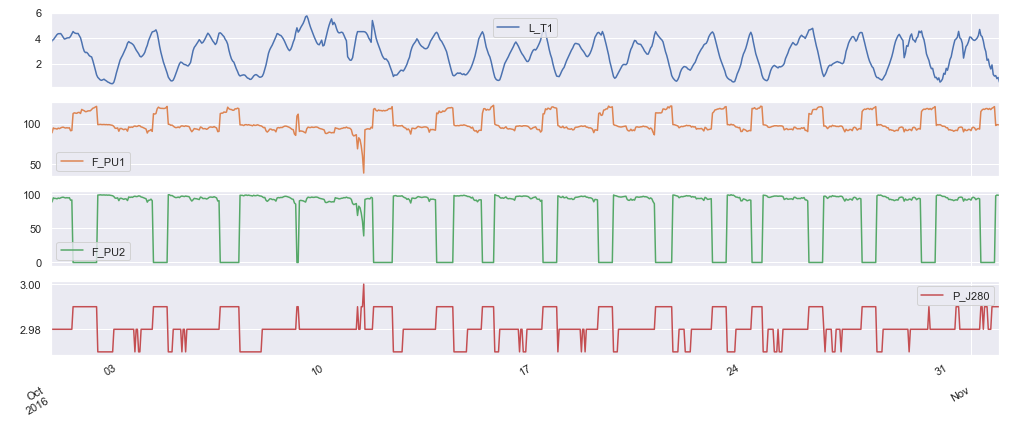

In [11]:
cols_plot = ['L_T1', 'F_PU1', 'F_PU2', 'P_J280']
axes = data_trn_2.loc['2016-10-01':'2016-11-01'][cols_plot].plot(figsize=(17, 7), subplots=True) 
plt.show()